# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Для начала проведем исследовательский анализ данных.

**Загрузим необходимые библиотеки**

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

**Загрузим датасет**

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

**Посмотрим на размеры датасета**

In [3]:
labels.shape

(7591, 2)

Размеры датасета достаточно большие, около 8 тысяч фотографий. Этого должно хватить для обучения модели.

**Посмотрим на распределение возраста в выборке**

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

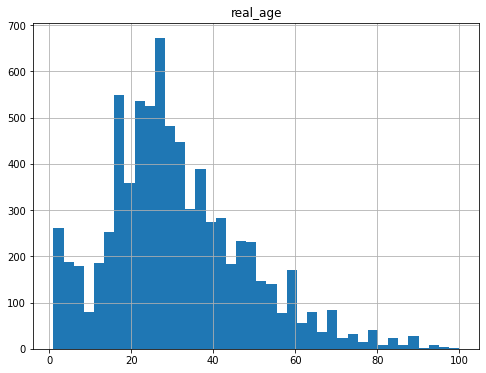

In [4]:
labels.hist(column='real_age', bins=40, figsize=(8, 6))

Видно, что в распределнии наблюдается бимодальность. То есть в датасете много фотографий детей и фотографий людей со средним возрастом около 30 лет. Это может привести к тому, что модель хуже будет предсказывать возраст пожилых, так как таких фотографий в датасете мало.

Посмотрим на среднее и медианное значения возраста.

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Среднее и медианное значение возраста почти совпадают и составляют 30 лет.

При этом не похоже, что в данных наблюдаются выбросы, так как минимальный возраст - 1 год, а максимальный - 100 лет.

**Напечатаем фотографии из датасета** 

Сначала выгрузим данные, сделав размер батча 12.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=12,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Разделим полученную выгрузку на features и target.

In [7]:
features, target = next(train_gen_flow)

Посмотрим на первые 12 фотографий, сверху каждой добавив возраст человека на фотографии.

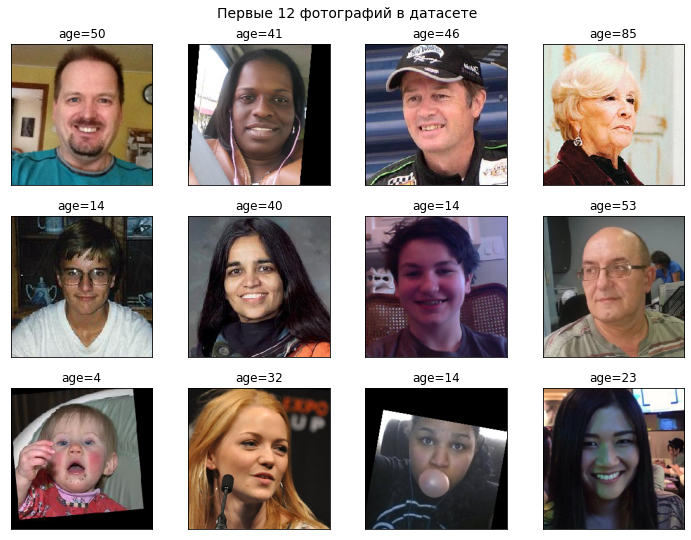

In [8]:
fig = plt.figure(figsize=(10,10))
plt.suptitle('Первые 12 фотографий в датасете', fontsize=14)
for i in range(12):
    fig.add_subplot(4, 4, i+1, title=f'age={str(target[i])}')
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

Среднее значение возраста для людей, присутствующих в выборке, составляет около 30 лет. Поэтому можно сделать предположение, что модель лучше научится предсказывать именно людей в данной возрастной категории.

Также по первым 12 фотографиям видно, что в датасете присутствуют люди разных рас. Поэтому также можно сделать предположение, что модели придется каким-то образом выделять характерные черты разного возраста людей, не учитывая их расу.

Что касается качества самих изображений, то по первым 12 фотографиям видно:
- Черно-белых фотографий нет.
- Некоторые фотографии немного повернуты. Однако, это может даже быть плюсом, так как наша модель научится определять возраст независимо от ориентации фотографии, что сделает ее более универсальной.

## Обучение модели

### Код обучения модели

```python
# Импортируем необходимые библиотеки
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import Callback

# Напишем функцию, которая загружает тренировочный датасет
def load_train(path):
    
    # Используем ImageDataGenerator для выгрузки данных
    # Значения будут нормированы на 1
    # 25 % данных пойдут в тестовую выборку
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)
    
    # Загрузим датасет с путями к картинкам и лейблами (возрастом человека на картинке)
    labels = pd.read_csv(path+'/labels.csv')

    # Выгрузим тренировочные данные, используя лейблы с датасета labels и разбив их на батчи величиной 16
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_datagen_flow

# Напишем функцию, которая загружает валидационный датасет
def load_test(path):
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)

    labels = pd.read_csv(path+'/labels.csv')

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

# Напишем функцию, которая создает модель
def create_model(input_shape):
    
    # Используем готовую нейронную сеть ResNet50 с 50 слоями
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    
    # Добавим свою "верхушку" нейронной сети
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    # В качестве алгоритма используем Adam
    optimizer = Adam(lr=0.001) 
    
    # Скомпилируем модель, используя MSE в качестве потерь и MAE в качестве метрики
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['mean_absolute_error']) 
    
    return model

# Напишем функцию, которая обучает модель
def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    # Создадим кастомный класс, который позволяет остановить обучение при определенном значении метрики
    class MyThresholdCallback(Callback):
        def __init__(self, threshold):
            super(MyThresholdCallback, self).__init__()
            self.threshold = threshold
    
        def on_epoch_end(self, epoch, logs=None): 
            MAE = logs["val_mean_absolute_error"]
            if MAE < self.threshold:
                self.model.stop_training = True
                
    # Создадим кастомный класс, который останавливает обучение при достижении MAE < 8
    earlystop_callback = MyThresholdCallback(threshold=8)
    
    # Проверим, подавали ли нам в качестве аргументов значения количества шагов для тренировочной или тестовой выборки
    # Если не подавали, установим в качестве количества шагов размеры соответствующих выборок
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    # Проведем обучение модели
    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs,
          callbacks=[earlystop_callback])

    return model 
```

###  Результат обучения модели

```python
2022-05-30 07:27:24.660515: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-05-30 07:27:24.662246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
/datasets/faces/
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-05-30 07:27:25.576018: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-30 07:27:26.249405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-30 07:27:26.249492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-30 07:27:26.249525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-30 07:27:26.251132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-30 07:27:26.251524: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-30 07:27:26.253691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-30 07:27:26.254850: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-30 07:27:26.254916: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-30 07:27:26.259290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-30 07:27:26.259615: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-05-30 07:27:26.266614: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-05-30 07:27:26.267150: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4611810 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-30 07:27:26.267174: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-30 07:27:26.409366: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4697830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-30 07:27:26.409405: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-05-30 07:27:26.411770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-30 07:27:26.411829: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-30 07:27:26.411840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-30 07:27:26.411872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-30 07:27:26.411883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-30 07:27:26.411894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-30 07:27:26.411905: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-30 07:27:26.411913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-30 07:27:26.416316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-30 07:27:26.416383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-30 07:27:26.729566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-30 07:27:26.729614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-05-30 07:27:26.729623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-05-30 07:27:26.734443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/30
2022-05-30 07:27:37.838980: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-30 07:27:38.138486: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 249.2117 - mean_absolute_error: 12.1341 - val_loss: 304.9269 - val_mean_absolute_error: 12.9631
Epoch 2/30
356/356 - 38s - loss: 183.9603 - mean_absolute_error: 10.4575 - val_loss: 281.7693 - val_mean_absolute_error: 12.7004
Epoch 3/30
356/356 - 38s - loss: 156.7062 - mean_absolute_error: 9.6361 - val_loss: 397.4956 - val_mean_absolute_error: 16.7278
Epoch 4/30
356/356 - 38s - loss: 132.7540 - mean_absolute_error: 8.8471 - val_loss: 182.9728 - val_mean_absolute_error: 10.0419
Epoch 5/30
356/356 - 38s - loss: 110.0985 - mean_absolute_error: 8.0785 - val_loss: 165.2873 - val_mean_absolute_error: 9.5607
Epoch 6/30
356/356 - 38s - loss: 89.3083 - mean_absolute_error: 7.2573 - val_loss: 210.3841 - val_mean_absolute_error: 10.7811
Epoch 7/30
356/356 - 38s - loss: 66.3064 - mean_absolute_error: 6.3191 - val_loss: 367.5283 - val_mean_absolute_error: 15.8686
Epoch 8/30
356/356 - 38s - loss: 50.6557 - mean_absolute_error: 5.6017 - val_loss: 123.1860 - val_mean_absolute_error: 8.6209
Epoch 9/30
356/356 - 38s - loss: 39.2363 - mean_absolute_error: 4.8819 - val_loss: 165.3479 - val_mean_absolute_error: 10.0844
Epoch 10/30
356/356 - 38s - loss: 30.1110 - mean_absolute_error: 4.2808 - val_loss: 120.1962 - val_mean_absolute_error: 8.2847
Epoch 11/30
356/356 - 38s - loss: 23.4217 - mean_absolute_error: 3.8013 - val_loss: 120.3043 - val_mean_absolute_error: 8.4784
Epoch 12/30
356/356 - 38s - loss: 20.2876 - mean_absolute_error: 3.4888 - val_loss: 133.7186 - val_mean_absolute_error: 8.6157
Epoch 13/30
356/356 - 38s - loss: 20.1104 - mean_absolute_error: 3.4527 - val_loss: 119.6263 - val_mean_absolute_error: 8.2843
Epoch 14/30
356/356 - 38s - loss: 18.6236 - mean_absolute_error: 3.3344 - val_loss: 176.6111 - val_mean_absolute_error: 10.5482
Epoch 15/30
356/356 - 38s - loss: 18.1563 - mean_absolute_error: 3.3031 - val_loss: 138.6112 - val_mean_absolute_error: 8.8482
Epoch 16/30
356/356 - 38s - loss: 17.5751 - mean_absolute_error: 3.2213 - val_loss: 111.5900 - val_mean_absolute_error: 8.1197
Epoch 17/30
356/356 - 38s - loss: 17.0922 - mean_absolute_error: 3.1894 - val_loss: 118.4329 - val_mean_absolute_error: 8.3928
Epoch 18/30
356/356 - 38s - loss: 16.2932 - mean_absolute_error: 3.1182 - val_loss: 135.1982 - val_mean_absolute_error: 9.0582
Epoch 19/30
356/356 - 38s - loss: 14.1654 - mean_absolute_error: 2.9048 - val_loss: 114.4095 - val_mean_absolute_error: 8.1459
Epoch 20/30
356/356 - 38s - loss: 13.3716 - mean_absolute_error: 2.8305 - val_loss: 111.8324 - val_mean_absolute_error: 8.2513
Epoch 21/30
356/356 - 38s - loss: 13.8480 - mean_absolute_error: 2.8541 - val_loss: 113.6117 - val_mean_absolute_error: 8.0145
Epoch 22/30
356/356 - 38s - loss: 14.7346 - mean_absolute_error: 2.9547 - val_loss: 129.1338 - val_mean_absolute_error: 8.4519
Epoch 23/30
356/356 - 38s - loss: 13.2425 - mean_absolute_error: 2.8037 - val_loss: 114.1816 - val_mean_absolute_error: 8.3297
Epoch 24/30
356/356 - 38s - loss: 12.3876 - mean_absolute_error: 2.7364 - val_loss: 107.1222 - val_mean_absolute_error: 7.7980
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 107.1222 - mean_absolute_error: 7.7980
Test MAE: 7.7980
```

## Анализ обученной модели

В данном проекте была построена модель, которая предсказывает возраст человека на фотографии:

- Были выгружены промаркированные данные с фотографиями людей различного возраста.
- Размер датасета - 7591 фотография.
- В распределении представленного возраста в датасете наблюдается бимодальность. Больше всего присутствует людей с возрастом около 30 лет и детей. Таким образом, модель может плохо научиться предсказывать возраст пожилых людей.
- Для обучения использовалась готовая нейронная сеть ResNet50 с 50 слоями. Предпоследним слоем было усреднение изображения в каждом слое изображения, которое попадает на вход. Последним слоем было предсказание возраста с активацией 'relu'. 
- После обучения удалось достичь метрики mean absolute error менее 8.

Что касается практического применения модели в бизнесе:
- Практическое применение модели ограничивается распределением возраста в датасете, на котором проводилось обучение.
- Распределение возраста людей в мире выглядит [следующим образом](https://commons.wikimedia.org/wiki/File:World_population_pyramid_(2018).jpg).
- В данных, которые использовались при обучении есть пик на возрасте около 30 лет. Поэтому для улучшения качества модели и приведения ее к "реальному" распределению возраста в мире, необходимо добавить в датасет больше фотографий людей с возрастом менее 30 лет.
- Но и в таком виде модель можно использовать для предсказаний, но при этом необходимо учитывать ее ограничения. Например, её не стоит использовать для предсказания возраста людей в школах или университетах, но можно использовать для предсказания возраста людей, работающих в различных компаниях, в которых в основном работают люди возраста около 30 лет.